In [1]:
# global Variables
RANDOM = 43

In [2]:
#import packages
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# sklearn standard imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, Binarizer, LabelEncoder, Normalizer, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# import decision tree
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

# import of pipe module
os.chdir('../preprocessing/')
import pipe

In [3]:
# calling preprocessing function

# num_to_cat = True: Range Date is now dtype Category 
# drop_filter: first method keep all, second drop not lab results

df = pipe.preprocessing_pipe(
                             num_to_cat   = True,
                             #drop_filter  = ['hla', 'specific_diagnosis'], 
                             #drop_filter  = ['hla', 'loc', 'specific_diagnosis'], 
                             drop_filter  = ['hla', 'ac_', 'vit_', 'gender', 'race', 'loc','specific_diagnosis'],
                             loc_approach = 'multi',
                             binary_cat   = True
                             #hotencode_gender = True,
                             #hotencode_race = True
                            ) 


In [4]:
print("missing in target are", df['cat'].isnull().sum())
percentil_cat = df.cat.value_counts(dropna=False)/len(df)
percentil_cat

missing in target are 0


idiopathic                  0.493482
systemic                    0.178771
not_uveitis                 0.131285
wds                         0.115456
infectious                  0.081006
scleritis                   0.000000
nonneoplastic masquerade    0.000000
neoplastic masquerade       0.000000
Name: cat, dtype: float64

In [5]:
df_t = df.copy().dropna()
features = df_t.drop(columns=['cat', 'uveitis']) # all features excluded target
target = df_t['cat'].cat.codes # target

# train-test split
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size = 0.25, random_state = RANDOM, stratify = None)

In [6]:
# filter for numeric and categorical features
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
category = ['category','bool']

# select list of numeric and categorical features
numeric_features = features.select_dtypes(include=numerics).columns.tolist()
categorical_features = features.select_dtypes(include=category).columns.tolist()

# define imputer strategy (consult sklarn SimpleImputer and StandardScaler documentation for options)
imputer = {'categorical':{'strategy':'most_frequent','fill_value':'most_frequent'}, 'numerical':{'strategy':'median', 'fill_value':'mean'}}
imputer_encoder = pipe.impute_and_encode(categorical_features, numeric_features, imputer, one_hot = False)

Accuracy: 0.5178571428571429
              precision    recall  f1-score   support

           0       0.55      0.93      0.69        90
           1       0.00      0.00      0.00        20
           4       0.20      0.16      0.18        19
           6       0.00      0.00      0.00        22
           7       0.00      0.00      0.00        17

    accuracy                           0.52       168
   macro avg       0.15      0.22      0.17       168
weighted avg       0.32      0.52      0.39       168

{'classifier__criterion': 'entropy', 'classifier__max_depth': 2}


C:\Users\Lupo_Remastered\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Lupo_Remastered\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Lupo_Remastered\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


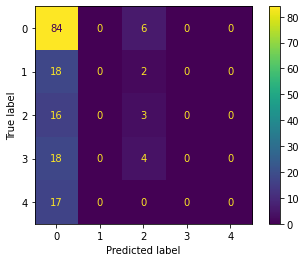

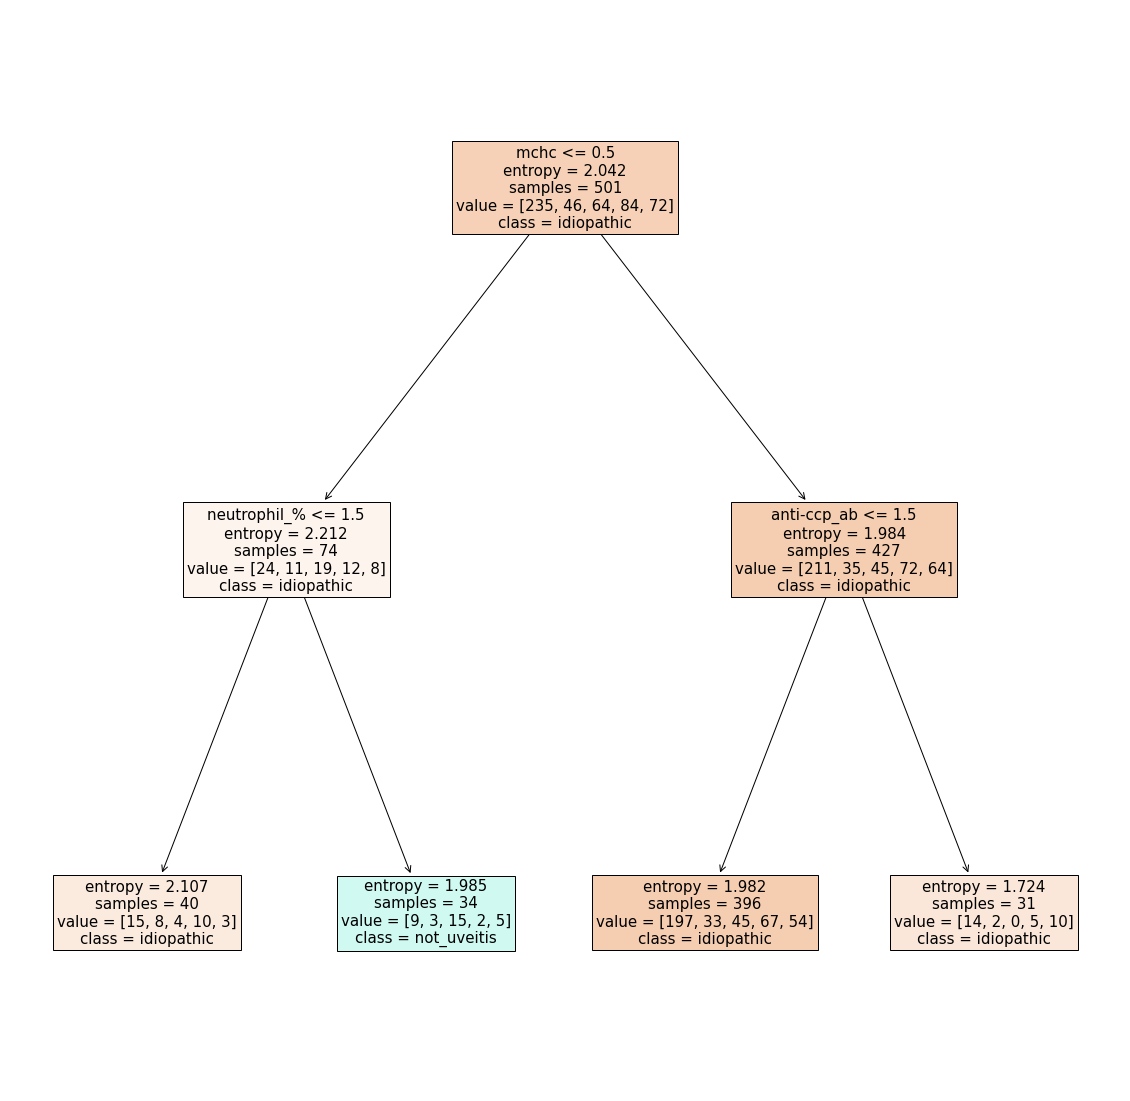

In [7]:
dectree = DecisionTreeClassifier()

pipeline = Pipeline(steps=[('preprocessor', imputer_encoder),
                      ('classifier', dectree)])

criterion = ['gini', 'entropy']
max_depth = [2,4,6,8,10,12]
class_weight = "balanced" #[{"idiopathic":0.49, "systemic":0.18, "not_uveitis":0.13, "wds":0.12, "infectious":0.08}]

parameters = {
             'classifier__criterion':criterion,
             'classifier__max_depth':max_depth,
             #'classifier__class_weight':class_weight
             }

# Instantiate the GridSearchCV object: cv
cv = GridSearchCV(pipeline, parameters, cv = 10)

# Fit to the training set
cv.fit(features_train, target_train)

# Predict the labels of the test set: target_pred
target_pred = cv.predict(features_test)

# Compute and print metrics
print("Accuracy: {}".format(cv.score(features_test, target_test)))
print(classification_report(target_test, target_pred))

ConfusionMatrixDisplay(confusion_matrix(target_test, target_pred)).plot();
print(cv.best_params_);

plt.figure(figsize=(20,20))
class_names = ['idiopathic', 'systemic', 'not_uveitis', 'wds', 'infectiuos']
feature_names = features_test.columns.tolist()
plot_tree(cv.best_estimator_[1], fontsize=15, class_names=class_names, feature_names=feature_names, filled=True)
plt.show()